In [1]:
import meep as mp
from meep import mpb
mp.verbosity(0)
import numpy as np
import matplotlib.pyplot as plt
from hexalattice.hexalattice import *

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [2]:
def calc_emission(component):
    
    N = 27 
    
    a = 405e-9 # nm
    t = 180e-9 / a
    
    c = 3e8

    fcen = 350e12 * a / c                                     # 340 THz(inside band-gap), since a = 405 nm, and c = 3e8: f=freq*a/c
    df = 50e12 * 2 * a / c
    
    nfreq = 500
    

    # The cell dimensions

    length = 30
    lengthz = 5

    cell = mp.Vector3(length, length, lengthz)                      # 3D case

    resolution = 4
    
    dpml = 1

    geometry = [mp.Block(center=mp.Vector3(0,0,0), 
            size=mp.Vector3(length-2*dpml,length-2*dpml,lengthz), 
            material=mp.Medium(index = 1))]                    # Block of air extending up to PML region 

    pml_layers = [mp.PML(dpml)]

    src = [mp.Source(src=mp.GaussianSource(fcen, fwidth=0.5),
                     center=mp.Vector3(x=0, y=0, z=0),
                     component=component, 
                     amplitude=1.0),
          ]

    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry = geometry,
                        sources=src,
                        resolution=resolution)
    
    pt = mp.Vector3(0.0,0.0)
    
    sim.run(mp.dft_ldos( fcen, df, nfreq),until_after_sources=mp.stop_when_fields_decayed(25,component,pt,1e-8))
    
    gi0=sim.ldos_data
    
    geometry = [mp.Block(center=mp.Vector3(0,0,0), 
            size=mp.Vector3(length-2*dpml,length-2*dpml,t), 
            material=mp.Medium(index = 2))]                    # Block of SiN extending up to PML region 

    # A hexagonal prism defined by six vertices centered on the origin
    # of material crystalline silicon (from the materials library)

    multiplier = (1-t)*0.5

    multiplier*1/np.sqrt(3)

    vertices = [mp.Vector3(0,multiplier*2/np.sqrt(3)),
                mp.Vector3(multiplier*1,multiplier*1/np.sqrt(3)),
                mp.Vector3(multiplier*1,-multiplier*1/np.sqrt(3)),
                mp.Vector3(0,multiplier*-2/np.sqrt(3)),
                mp.Vector3(-multiplier*1,-multiplier*1/np.sqrt(3)),
                mp.Vector3(-multiplier*1,multiplier*1/np.sqrt(3))]

    hex_centers, _ = create_hex_grid(nx=N, ny=N, crop_circ=N//2)

    for center in hex_centers: 
        center_final = mp.Vector3(center[0], center[1])
        geometry.append(mp.Prism(vertices,
                                         height=t,
                                         center=center_final,
                                         material=mp.Medium(index = 1))) #add the hexagons in the lattice
    
    sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=src,
                    resolution=resolution)
    
    
    tran_fr1 = mp.FluxRegion(volume=mp.Volume(center=mp.Vector3(0.5*length-dpml,0,0),size=mp.Vector3(0,length-2*dpml,lengthz-2*dpml)))
    tran_fr2 = mp.FluxRegion(volume=mp.Volume(center=mp.Vector3(-0.5*length+dpml,0,0),size=mp.Vector3(0,length-2*dpml,lengthz-2*dpml)))

    tran_fr3 = mp.FluxRegion(volume=mp.Volume(center=mp.Vector3(0,0.5*length-dpml,0),size=mp.Vector3(length-2*dpml,0,lengthz-2*dpml)))
    tran_fr4 = mp.FluxRegion(volume=mp.Volume(center=mp.Vector3(0,-0.5*length+dpml,0),size=mp.Vector3(length-2*dpml,0,lengthz-2*dpml)))

    tran_fr5 = mp.FluxRegion(volume=mp.Volume(center=mp.Vector3(0,0,0.5*lengthz-dpml),size=mp.Vector3(length-2*dpml,length-2*dpml,0)))
    tran_fr6 = mp.FluxRegion(volume=mp.Volume(center=mp.Vector3(0,0,-0.5*lengthz+dpml),size=mp.Vector3(length-2*dpml,length-2*dpml,0)))
    

    tran1 = sim.add_flux(fcen, df, nfreq , tran_fr1)
    tran2 = sim.add_flux(fcen, df, nfreq , tran_fr2)
    tran3 = sim.add_flux(fcen, df, nfreq , tran_fr3)
    tran4 = sim.add_flux(fcen, df, nfreq , tran_fr4)
    tran5 = sim.add_flux(fcen, df, nfreq , tran_fr5)
    tran6 = sim.add_flux(fcen, df, nfreq , tran_fr6)

    mode1 = sim.add_mode_monitor(fcen, df, nfreq , tran_fr1)
    mode2 = sim.add_mode_monitor(fcen, df, nfreq , tran_fr2)
    mode3 = sim.add_mode_monitor(fcen, df, nfreq , tran_fr3)
    mode4 = sim.add_mode_monitor(fcen, df, nfreq , tran_fr4)
    mode5 = sim.add_mode_monitor(fcen, df, nfreq , tran_fr5)
    mode6 = sim.add_mode_monitor(fcen, df, nfreq , tran_fr6)
    
    sim.run(mp.dft_ldos( fcen, df, nfreq),until=200)
    
    gi=sim.ldos_data
    
    emission_rate_tot = np.array(gi)/np.array(gi0)
    
    res1 = sim.get_eigenmode_coefficients(mode1,[1])
    res2 = sim.get_eigenmode_coefficients(mode2,[1])
    res3 = sim.get_eigenmode_coefficients(mode3,[1])
    res4 = sim.get_eigenmode_coefficients(mode4,[1])
    res5 = sim.get_eigenmode_coefficients(mode5,[1])
    res6 = sim.get_eigenmode_coefficients(mode6,[1])

    res1_coeffs = res1.alpha
    res2_coeffs = res2.alpha
    res3_coeffs = res3.alpha
    res4_coeffs = res4.alpha
    res5_coeffs = res5.alpha
    res6_coeffs = res6.alpha
    
    tran_flux = np.array([mp.get_fluxes(tran1),mp.get_fluxes(tran2),mp.get_fluxes(tran3),mp.get_fluxes(tran4),mp.get_fluxes(tran5),mp.get_fluxes(tran6)])
    Gamma_2D = abs(res2_coeffs[0,:,0])**2+ abs(res2_coeffs[0,:,1])**2+abs(res1_coeffs[0,:,0])**2+abs(res1_coeffs[0,:,1])**2 + abs(res4_coeffs[0,:,1])**2   + abs(res4_coeffs[0,:,0])**2+abs(res3_coeffs[0,:,0])**2+abs(res3_coeffs[0,:,1])**2 + abs(res6_coeffs[0,:,1])**2+ abs(res6_coeffs[0,:,0])**2+abs(res5_coeffs[0,:,0])**2+abs(res5_coeffs[0,:,1])  
    Gamma_prime = np.sum(np.abs(tran_flux),axis=0) - Gamma_2D
    
    
    
    Gamma_2D_over_prime = Gamma_2D / Gamma_prime
    
    return emission_rate_tot, tran_flux, Gamma_2D, Gamma_2D_over_prime

In [3]:
emission_rate, tran_flux, Gamma_2D, Gamma_2D_over_prime = calc_emission(mp.Ex)

ldos0:, 0.40499999999999997, 0.22357033614147287
ldos0:, 0.4052705410821643, 0.2238808630387705
ldos0:, 0.4055410821643286, 0.22419155482550865
ldos0:, 0.40581162324649295, 0.22450240260662385
ldos0:, 0.4060821643286573, 0.22481339777786513
ldos0:, 0.40635270541082164, 0.22512453206512595
ldos0:, 0.4066232464929859, 0.22543579756140625
ldos0:, 0.40689378757515027, 0.22574718676112607
ldos0:, 0.4071643286573146, 0.2260586925915724
ldos0:, 0.40743486973947896, 0.22637030844126932
ldos0:, 0.40770541082164324, 0.226682028185103
ldos0:, 0.4079759519038076, 0.2269938462060801
ldos0:, 0.40824649298597193, 0.22730575741360104
ldos0:, 0.4085170340681362, 0.22761775725820715
ldos0:, 0.40878757515030056, 0.22792984174277428
ldos0:, 0.4090581162324649, 0.22824200743014408
ldos0:, 0.40932865731462925, 0.22855425144727395
ldos0:, 0.40959919839679354, 0.2288665714859573
ldos0:, 0.4098697394789579, 0.2291789658002338
ldos0:, 0.41014028056112223, 0.2294914332006579
ldos0:, 0.41041082164328657, 0.229803

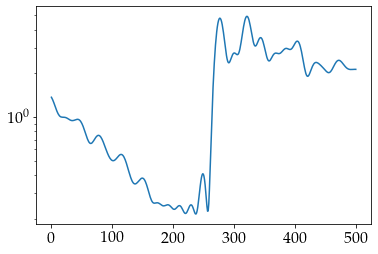

In [4]:
plt.plot(emission_rate)
plt.yscale('log')

In [5]:
print(np.shape(np.sum(np.abs(tran_flux),axis=0)))

(500,)


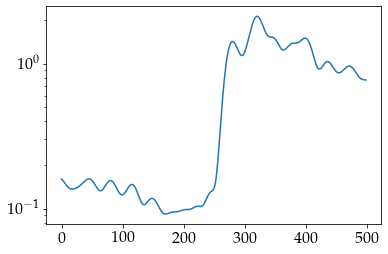

In [6]:
plt.plot(np.sum(np.abs(tran_flux),axis=0))
plt.yscale('log')

In [7]:
print(np.shape(Gamma_2D))

(500,)


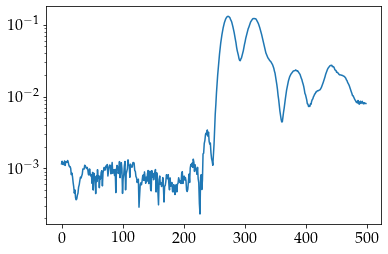

In [8]:
plt.plot(Gamma_2D)
plt.yscale('log')

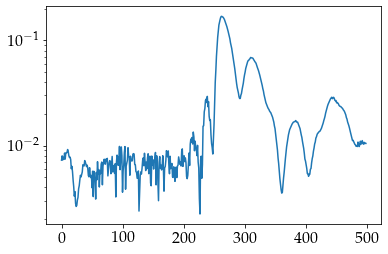

In [9]:
plt.plot(Gamma_2D_over_prime)
plt.yscale('log')

## RUN ON LAKS